**Fonte**: https://www.kaggle.com/luisfredgs/imdb-ptbr


In [107]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import unidecode
import nltk
from nltk import tokenize
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer

In [108]:
%matplotlib inline

In [109]:
df_data = pd.read_csv('../data/imdb-reviews-pt-br.csv.zip')
df_data.sample()


,id,text_en,text_pt,sentiment
37021,37023,I agree totally with another of the reviewers ...,Concordo totalmente com outro dos revisores aq...,neg


In [110]:
df_data["sentiment"].value_counts(normalize=True)


neg    0.500718
pos    0.499282
Name: sentiment, dtype: float64

In [111]:
df_data["sentiment_int"] = df_data["sentiment"].replace({"pos": 1, "neg": 0})
df_data.sample(5)

,id,text_en,text_pt,sentiment,sentiment_int
3057,3059,"This should have been a short film, nothing mo...","Este deveria ter sido um curta-metragem, nada ...",neg,0
39654,39656,"A mix of comedy, romance, music?!, action and ...","Uma mistura de comédia, romance, música?!, Açã...",pos,1
18005,18007,"by TyNesha Mells. In this drama, Ja Rule, who ...","por TyNesha Mells. Nesse drama, Ja Rule, que e...",pos,1
15767,15769,I dont normally go out of my way to watch roma...,Eu normalmente não saio do meu caminho para as...,pos,1
34220,34222,"An average TV movie quality, totally formula s...","Uma média de qualidade de filme de TV, totalme...",neg,0


# Bag of words

In [112]:
# CountVector
vectorization = CountVectorizer(lowercase=False, max_features=50)
bag_of_words = vectorization.fit_transform(df_data["text_pt"])
bag_of_words.shape


(49459, 50)

In [113]:
train, test, y_train, y_test = ms.train_test_split(
    bag_of_words, df_data["sentiment_int"], random_state=42)


In [114]:
reg = LogisticRegression()
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
print(acuracy)


0.6583097452486858


In [115]:
def classification_text(df, column_text, column_sentiment):
    vectorization = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vectorization.fit_transform(df[column_text])
    train, test, y_train, y_test = ms.train_test_split(
        bag_of_words, df[column_sentiment], random_state=42)
    reg = LogisticRegression()
    reg.fit(train, y_train)
    acuracy = reg.score(test, y_test)
    return acuracy


In [116]:
classification_text(df_data, "text_pt", "sentiment_int")

0.6583097452486858

In [117]:
all_words = ' '.join([text for text in df_data["text_pt"]])

In [118]:
def plot_word_cloud(text, title):
    word_cloud = WordCloud(
        width=800,
        height=500,
        max_font_size=110,
        collocations=False
    ).generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.title(title, fontdict={"fontsize": 24, "color": "white"})
    plt.axis("off")
    plt.show()
    plt.close()


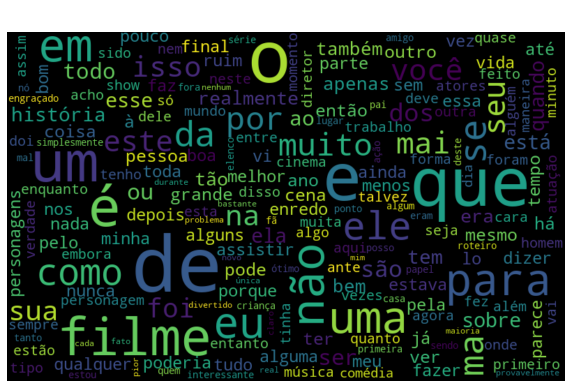

In [119]:
plot_word_cloud(all_words, "All words")


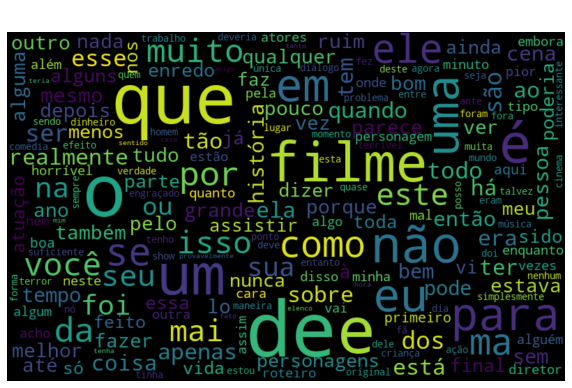

In [120]:
all_words_neg = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"]==0]["text_pt"]])
plot_word_cloud(all_words_neg, "Negative words")


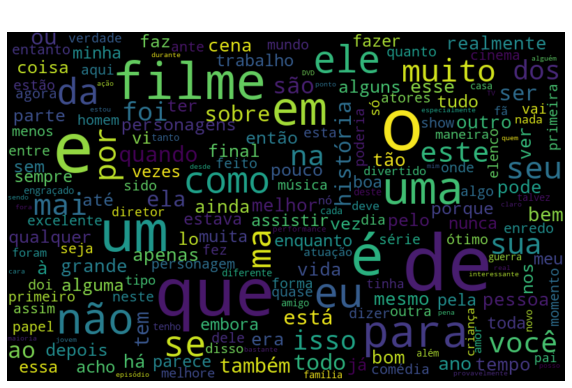

In [121]:
all_words_pos = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"] == 1]["text_pt"]])
plot_word_cloud(all_words_pos, "Positive words")


In [122]:
tokenize_whitespace = tokenize.WhitespaceTokenizer()
tokenize_all_words = tokenize_whitespace.tokenize(all_words)
freq = nltk.FreqDist(tokenize_all_words)

In [123]:
df_freq = pd.DataFrame({"word":freq.keys(), "freq":freq.values()})
df_freq.nlargest(columns="freq", n=10)


,word,freq
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


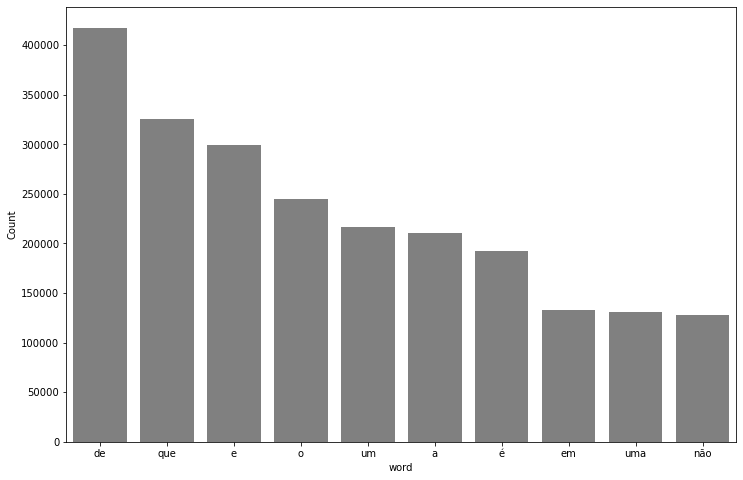

In [124]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_freq.nlargest(columns="freq", n=10),
    x="word",
    y="freq",
    color="gray"
)
ax.set(ylabel="Count")
plt.show()


In [125]:
def plot_freq_dist(df, column_filter, title, n=10):
    analyzed_words = ' '.join(
        [text for text in df[column_filter]]
    )

    tokenize_whitespace = tokenize.WhitespaceTokenizer()
    tokenize_all_words = tokenize_whitespace.tokenize(analyzed_words)
    freq = nltk.FreqDist(tokenize_all_words)
    df_freq = pd.DataFrame({"word": freq.keys(), "freq": freq.values()})
    df_freq = df_freq.nlargest(columns="freq", n=n)
    df_freq["freq_normalize_accumulated"] = (
        100 * df_freq["freq"].cumsum()/df_freq["freq"].sum())

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=df_freq,
        x="word",
        y="freq",
        color="gray"
    )
    ax2 = ax.twinx()
    sns.lineplot(data=df_freq, x='word', y='freq_normalize_accumulated',
                 color='red', sort=False, ax=ax2)
    ax.set(ylabel="Count")
    plt.title(title, fontdict={"fontsize": 24, "color": "white"})
    plt.show()
    plt.close()


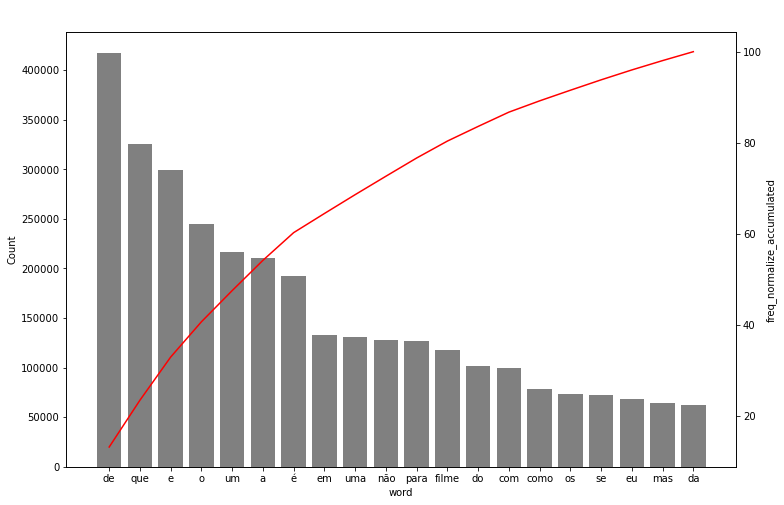

In [126]:
plot_freq_dist(df_data,  "text_pt", "All words", n=20)


In [127]:
def remove_accents(text):
    return unidecode.unidecode(text)

In [128]:
def remove_stop_words(text):
    stop_words = list(
        dict.fromkeys(
            nltk.corpus.stopwords.words("portuguese") +
            [remove_accents(word) for word in nltk.corpus.stopwords.words("portuguese")]
        )
    )
    tokenize_whitespace = tokenize.WhitespaceTokenizer()
    tokenize_all_words = tokenize_whitespace.tokenize(text)
    return " ".join([word for word in tokenize_all_words if word not in stop_words])


In [129]:
def remove_punctuation(text):
    tokenize_punctuation = tokenize.WordPunctTokenizer()
    tokenize_all_words = tokenize_punctuation.tokenize(text)
    return " ".join([word for word in tokenize_all_words if word not in punctuation])
   

In [130]:
stemmer = nltk.stem.RSLPStemmer()

def stemming(text):
    tokenize_whitespace = tokenize.WhitespaceTokenizer()
    tokenize_all_words = tokenize_whitespace.tokenize(text)
    return " ".join([stemmer.stem(word) for word in tokenize_all_words])

In [131]:
df_data["text_processed"] = df_data["text_pt"].apply(remove_accents).str.lower()
df_data["text_processed"] = df_data["text_processed"].apply(remove_stop_words)
df_data["text_processed"] = df_data["text_processed"].apply(remove_punctuation)
df_data["text_processed"] = df_data["text_processed"].apply(stemming)
df_data.head(10)


,id,text_en,text_pt,sentiment,sentiment_int,text_processed
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,vez sr costn arrum film temp necessari alem te...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,exempl motiv maior film aca mesm gener chat na...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,prim tud odei rap imbecil pod agir arm pressio...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,beatl pud escrev music tod gost emb walt hill ...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,film fot lata palavr apropri ele verdad tant o...
5,6,"A funny thing happened to me while watching ""M...",Uma coisa engraçada aconteceu comigo enquanto ...,neg,0,cois engrac acontec comig enquant assist mosqu...
6,7,This German horror film has to be one of the w...,Este filme de terror alemão tem que ser um dos...,neg,0,film terr alema ser estranh vi cient qualqu co...
7,8,"Being a long-time fan of Japanese film, I expe...","Sendo um fã de longa data do cinema japonês, e...",neg,0,send fa long dat cinem japon esper iss real po...
8,9,"""Tokyo Eyes"" tells of a 17 year old Japanese g...","""Tokyo Eyes"" fala de uma menina japonesa de 17...",neg,0,toky eye fal menin japon 17 ano cai hom send c...
9,10,Wealthy horse ranchers in Buenos Aires have a ...,Fazendeiros ricos em Buenos Aires têm uma long...,neg,0,fazend ric buen air long poli nao comerci craw...


In [132]:
classification_text(df_data, "text_processed", "sentiment_int")


0.697048119692681

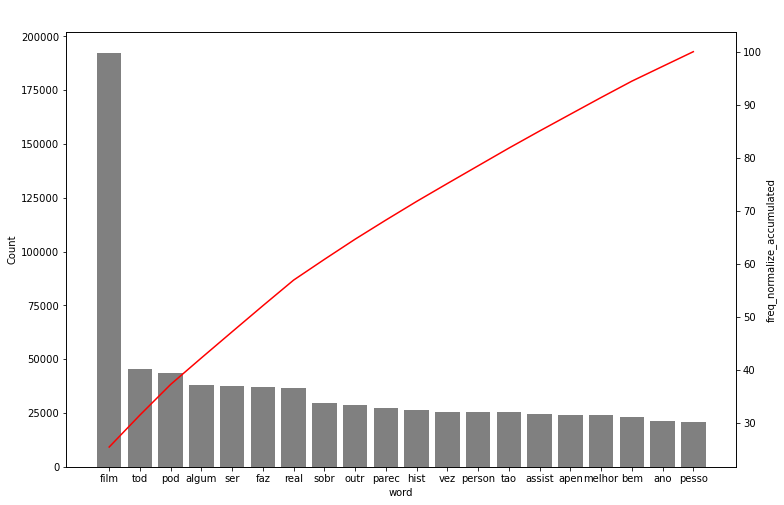

In [133]:
plot_freq_dist(df_data,  "text_processed", "All words processed", n=20)


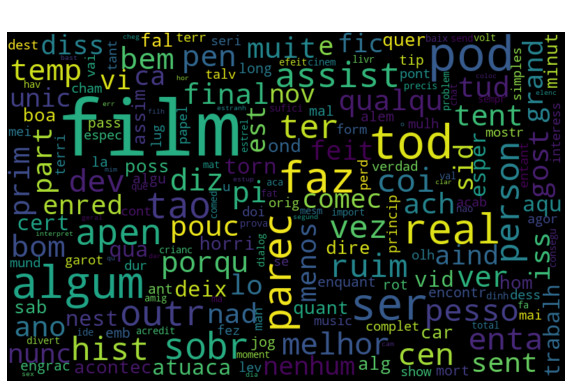

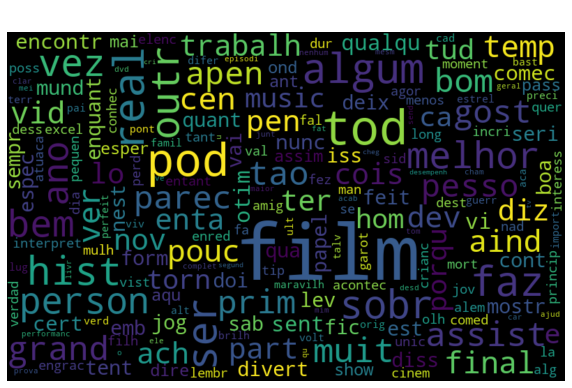

In [134]:
all_words_neg = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"] == 0]["text_processed"]])
plot_word_cloud(all_words_neg, "Negative words")

all_words_pos = ' '.join(
    [text for text in df_data.loc[df_data["sentiment_int"] == 1]["text_processed"]])
plot_word_cloud(all_words_pos, "Positive words")

In [135]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_words = tfidf.fit_transform(df_data["text_pt"])
train, test, y_train, y_test = ms.train_test_split(tfidf_words, df_data["sentiment_int"], random_state=42)
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
acuracy

0.6600889607763849

In [136]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_words = tfidf.fit_transform(df_data["text_processed"])
train, test, y_train, y_test = ms.train_test_split(
    tfidf_words, df_data["sentiment_int"], random_state=42)
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
acuracy


0.6965628790942175

In [137]:

tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))
tfidf_words = tfidf.fit_transform(df_data["text_processed"])
train, test, y_train, y_test = ms.train_test_split(
    tfidf_words, df_data["sentiment_int"], random_state=42)
reg.fit(train, y_train)
acuracy = reg.score(test, y_test)
acuracy


0.8863728265264861

In [138]:
weigh_word = pd.DataFrame(reg.coef_[0].T, index=tfidf.get_feature_names_out())
weigh_word.nlargest(10,0)


,0
otim,9.867615
excel,9.006156
perfeit,6.911005
maravilh,6.270806
favorit,5.903317
incri,5.745270
divert,5.436074
brilh,4.858607
ador,4.567247
hoj,4.490757


In [139]:
weigh_word.nsmallest(10,0)

,0
ruim,-11.797601
pi,-11.441223
horri,-9.699996
terri,-8.378708
nad,-7.599854
chat,-7.512436
parec,-6.648253
nenhum,-6.365132
tent,-5.771398
mal,-5.715208
